In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [96]:
df = pd.read_csv('Raw_Data.csv',header=0).round(1)

In [97]:
#Original Data
df.head()

,%T254,%T215,Flow,UVS,Actual Power,N,RED
0,88.6,63.3,257.6,23.2,6.0,2,71.0
1,88.6,63.3,257.6,23.3,6.0,2,72.8
2,88.6,63.3,257.6,23.3,6.0,2,73.6
3,93.0,82.8,189.1,24.6,3.5,2,98.1
4,93.0,82.8,189.1,24.7,3.5,2,98.8


In [98]:
#Synthetic data for 1 and 2 lamps - based on UV dose multiplication
df1 = df.loc[df['N']==1].copy()
df1.loc[:, 'RED']*=2
df1.loc[:, 'N']=2

df2 = df.loc[df['N']==2].copy()
df2.loc[:, 'RED']/=2
df2.loc[:, 'N']=1

df=df.append(df1,ignore_index=True)
df=df.append(df2,ignore_index=True)

In [99]:
# Duplicate the situation for 3 and 4 lamps:
df_3 = df.loc[df['N']==1].copy()
df2.loc[:, 'RED']*=3
df2.loc[:, 'N']=3

df_4 = df.loc[df['N']==2].copy()
df2.loc[:, 'RED']*=2
df2.loc[:, 'N']=4

df=df.append(df_3,ignore_index=True)
df=df.append(df_4,ignore_index=True)

<AxesSubplot:xlabel='%T254', ylabel='%T215'>

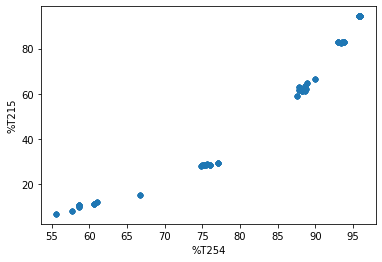

In [100]:
df.plot.scatter(x='%T254',y='%T215')

In [101]:
# Transform UVT into exp(-UVT/100)
df['%T254'] = np.exp(-df['%T254']/100)
df['%T215'] = np.exp(-df['%T215']/100)

In [102]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_features = sc.fit_transform(df.values)
#restore column names
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [103]:
X = scaled_features_df.drop('RED',axis=1)
y = scaled_features_df['RED']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [106]:
# Meta-Parameters:
Dense1 = 10
Dense2 = 4
LearningRate = 0.01
dropout = 0.1
GNoise = 0.1
Epochs = 100

L2regularization = 0.02
Bias_regularization = 0.02

#Features
Features = 6

In [107]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(Features,)))
model1.add(GaussianNoise(GNoise))
#model1.add(Dense(Dense1, 'softmax'))
model1.add(Dense(Dense1, kernel_regularizer=l2(L2regularization), bias_regularizer=l2(Bias_regularization), activation='softmax'))
model1.add(Dropout(dropout))
model1.add(Dense(Dense2, 'softmax'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_4 (GaussianNo (None, 6)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                70        
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 44        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 119
Trainable params: 119
Non-trainable params: 0
_________________________________________________________________


In [108]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LearningRate), metrics=[RootMeanSquaredError()])

In [109]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=Epochs)

Epoch 1/100
6/6 [==============================] - 0s 34ms/step - loss: 1.2802 - root_mean_squared_error: 1.0574 - val_loss: 0.9076 - val_root_mean_squared_error: 0.8791
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 1.2109 - root_mean_squared_error: 1.0431 - val_loss: 0.8626 - val_root_mean_squared_error: 0.8724
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 1.1684 - root_mean_squared_error: 1.0373 - val_loss: 0.8277 - val_root_mean_squared_error: 0.8666
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1295 - root_mean_squared_error: 1.0289 - val_loss: 0.8045 - val_root_mean_squared_error: 0.8625
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 1.0992 - root_mean_squared_error: 1.0210 - val_loss: 0.7814 - val_root_mean_squared_error: 0.8550
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 1.0689 - root_mean_squared_error: 1.0104 - val_loss: 0.7552 - val_root_mean_squared

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


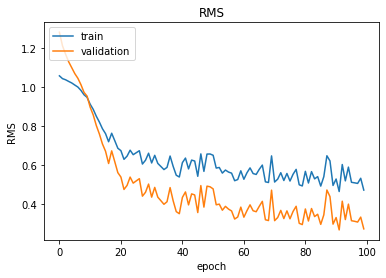

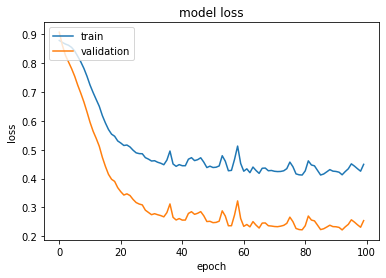

In [110]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['loss'])
plt.title('RMS')
plt.ylabel('RMS')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_root_mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [111]:
test_predictions = model1.predict(X_test)

In [112]:
X_test.insert(6,'RED',test_predictions)
y_pred = sc.inverse_transform(X_test)[:,Features]
X_test.drop('RED',axis=1).insert(Features,'RED',y_test)
y_test = sc.inverse_transform(X_test)[:,Features]

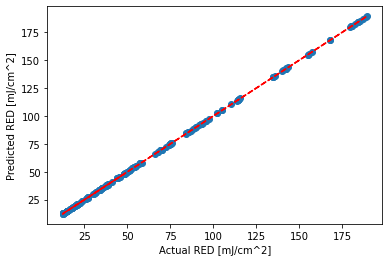

In [113]:
from numpy.polynomial.polynomial import polyfit
plt.scatter(y_test,y_pred)
# Fit with polyfit
b, m = polyfit(y_test, y_pred, 1)
plt.plot(y_test, b + m * y_test, '--', color='red')
plt.xlabel("Actual RED [mJ/cm^2]")
plt.ylabel("Predicted RED [mJ/cm^2]")
plt.show()

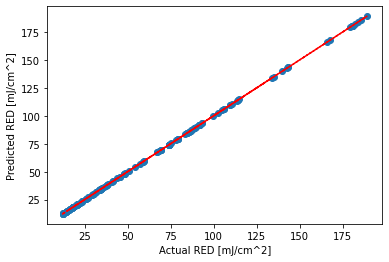

In [114]:
val_predictions = model1.predict(X_val)

X_val.insert(6,'RED',val_predictions)
y_pred = sc.inverse_transform(X_val)[:,Features]
X_val.drop('RED',axis=1).insert(Features,'RED',y_val)
y_val = sc.inverse_transform(X_val)[:,Features]

plt.scatter(y_val,y_pred)
# Fit with polyfit
b, m = polyfit(y_val, y_pred, 1)
plt.plot(y_val, b + m * y_val, '--', color='red')
plt.xlabel("Actual RED [mJ/cm^2]")
plt.ylabel("Predicted RED [mJ/cm^2]")
plt.show()

In [115]:
# Save model and scaler
from pickle import dump
model1.save('SavedModel_RED/REDmodel.h5')
#dump(model1, open('SavedModel_RED/REDmodel.pkl', 'wb'))
dump(sc, open('SavedModel_RED/scaler.pkl', 'wb'))

In [116]:
# Features format is as following:
# %T254,%T215,Flow,UVS,Actual Power,N,RED

# RED is the target

In [117]:
# Single testing point:
#88.6,63.3,257.6,23.18,6.0,2,70.98
#Target RED = 70.98

UVT254 = 88.6 # [%-1cm]
UVT215 = 63.3 # [%-1cm]
Flow = 258 # [m^3/hr]
UVS = 23.2 # [mJ/cm^2] - UV sensitivity aka D1Log
Power = 6 # [kW]
N_Lamps = 2

X_vector = sc.transform(pd.DataFrame([np.exp(-UVT254/100),np.exp(-UVT215/100),Flow,UVS,Power,N_Lamps,1]).T)[:,:Features]
# Dummy values added before the inverse transform due to the scaler preferences
RED = sc.inverse_transform([1,1,1,1,1,1,float(model1.predict(X_vector))])[Features]

In [118]:
print('RED = {}[mJ/cm^2]'.format(round(float(RED),1)))

RED = 83.3[mJ/cm^2]
